In [ ]:
#@title # Run to Setup
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import *
from keras.optimizers import *

from IPython.display import clear_output

# Mount my google drive
from google.colab import drive
clear_output()
print("Mount Google Drive Now")
drive.mount('/content/gdrive')

# Dataset file structure information
sentinel_1_folder       = "SENTINEL-1 SAR"
cmems_label_folder      = "CMEMS Concentration"
validations_folder      = "Image Processing Validation"

# Input image path information
# (Only use when in the "SENTINEL-1 SAR" folder)
sentinel_1_quicklook_name = "Quick Look Images/{0}/{1}/{2}/{0}_{1}_{2}_{3}.png" # 0:YEAR, 1:MONTH, 2:DAY, 3:UUID
sentinel_1_resampled_name = "Resampled Images/{0}/{1}/{2}/{0}_{1}_{2}_{3}.png" # 0:YEAR, 1:MONTH, 2:DAY, 3:UUID

# Label image path information
# (Only use when in the "CMEMS Boundary" folder)
concentration_name = "Concentration Labels/{0}/{1}/{2}/{0}_{1}_{2}_{3}.png" # 0:YEAR, 1:MONTH, 2:DAY, 3:UUID
uncertainty_name   = "Uncertainty Labels/{0}/{1}/{2}/{0}_{1}_{2}_{3}.png" # 0:YEAR, 1:MONTH, 2:DAY, 3:UUID

# Models folder location
model_location_path = "/content/gdrive/My Drive/AKM05/Models"

# Dimension of all input images and labels (assume nxn)
image_dimension = 128

# Batch size for training and testing
batch_size = 16
seed = 1

# Show the available datasets
clear_output()

dataset_location_path   = "/content/gdrive/My Drive/AKM05/DataSets"
print("The following datasets are available:")
for name in os.listdir(dataset_location_path):
  print("\t" + name)
print("Please choose one and use it in the following cell.")

The following datasets are available:
	Pangaea_2019
	Southern_Freezing_3_20190901_20191130
	Southern_Melting_3_20200101_20200331
	Northern_Freezing_6_20200101_20200630
	Southern_Freezing_6_20200401_20200930
	Northern_Melting_3_20200801_20201029
	Southern_Melting_6_20200101_20200630
	Data Information.gdoc
Please choose one and use it in the following cell.


In [ ]:
#@title Please enter the dataset name
dataset_name = "Southern_Melting_6_20200101_20200630" #@param {type:"string"}

# Check if the dataset exists
os.chdir(dataset_location_path)
if dataset_name  in os.listdir():
  print("Dataset found! OK to continue.")
  os.chdir(os.path.join(dataset_location_path, dataset_name))
else:
  print("Dataset does not exist. Please check the name and dates, then try again.")

Dataset found! OK to continue.


# Batch Set Preparation

In [ ]:
#@title ## Get all existing batch sets
# Function to split the dataset and save the txt files
def split_dataset():
  print("Splitting dataset now.")
  os.chdir(os.path.join(dataset_location_path, dataset_name))
  
  # Read in the 'good' samples, and split for train/test
  samples_dataframe      = pd.read_csv("Samples.txt", header=None, names=["date_uuid"])
  test_dataframe         = samples_dataframe.sample(frac=0.2, random_state=seed)
  train_dataframe        = samples_dataframe.drop(test_dataframe.index)

  # Read in the 'bad' samples, and select a number of them for testing later on
  test_ignored_dataframe = pd.read_csv("Ignored Samples.txt", header=None, names=["date_uuid"])
  test_ignored_dataframe = test_ignored_dataframe.sample(n=min(100, len(test_ignored_dataframe['date_uuid'])), random_state=seed)

  # Print a summary
  print("Dataset has just been split.\n{} for training, {} for testing, and {} from the ignored samples.".format(len(train_dataframe['date_uuid']), len(test_dataframe['date_uuid']), len(test_ignored_dataframe['date_uuid'])))

  # Save the split lists to file
  os.chdir(os.path.join(dataset_location_path, dataset_name, "Batches"))
  train_dataframe.to_csv("Train.txt", header=False, index=False, mode='w')
  test_dataframe.to_csv("Test.txt", header=False, index=False, mode='w')
  test_ignored_dataframe.to_csv("Test_Ignored.txt", header=False, index=False, mode='w')
  print("The split sets have been saved to file for future use.")

# Function to generate and save the image batches
def generate_batches(augmentation_args):
  # Image preprocessing functions applied at batch time
  def image_preprocessing(img):
    return img

  def concentration_preprocessing(img):
    img[:, :, 0] = cv2.medianBlur(img, 5)
    return img

  def uncertainty_preprocessing(img):
    img[:, :, 0] = cv2.medianBlur(img, 5)
    return img
  
  # Add a column for the file paths, generated from the file name
  train_dataframe["path"]         = ["{}/{}/{}/{}.png".format(name.split("_")[0], name.split("_")[1], name.split("_")[2], name) for name in train_dataframe['date_uuid']]
  test_dataframe["path"]          = ["{}/{}/{}/{}.png".format(name.split("_")[0], name.split("_")[1], name.split("_")[2], name) for name in test_dataframe['date_uuid']]
  test_ignored_dataframe["path"]  = ["{}/{}/{}/{}.png".format(name.split("_")[0], name.split("_")[1], name.split("_")[2], name) for name in test_ignored_dataframe['date_uuid']]

  # Create DataGenerator objects
  train_image_datagen               = ImageDataGenerator(rescale=1./255, **augmentation_args, preprocessing_function=image_preprocessing)
  train_label_datagen               = ImageDataGenerator(rescale=1./100, **augmentation_args, preprocessing_function=concentration_preprocessing)
  train_uncertainty_datagen         = ImageDataGenerator(rescale=1./100, **augmentation_args, preprocessing_function=uncertainty_preprocessing)

  test_image_datagen                = ImageDataGenerator(rescale=1./255, preprocessing_function=image_preprocessing)
  test_label_datagen                = ImageDataGenerator(rescale=1./100, preprocessing_function=concentration_preprocessing)
  test_uncertainty_datagen          = ImageDataGenerator(rescale=1./100, preprocessing_function=uncertainty_preprocessing)

  test_ignored_image_datagen        = ImageDataGenerator(rescale=1./255, preprocessing_function=image_preprocessing)
  test_ignored_label_datagen        = ImageDataGenerator(rescale=1./100, preprocessing_function=concentration_preprocessing)
  test_ignored_uncertainty_datagen  = ImageDataGenerator(rescale=1./100, preprocessing_function=uncertainty_preprocessing)

  # Set the DataGens to flow from the dataframe paths
  train_image_generator              =              train_image_datagen.flow_from_dataframe(train_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, sentinel_1_folder, "Resampled Images"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="rgb",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False,
                                                                                            seed=seed)
  train_label_generator              =              train_label_datagen.flow_from_dataframe(train_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, cmems_label_folder, "Concentration Labels"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="grayscale",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False,
                                                                                            seed=seed)
  train_uncertainty_generator        =        train_uncertainty_datagen.flow_from_dataframe(train_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, cmems_label_folder, "Uncertainty Labels"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="grayscale",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False,
                                                                                            seed=seed)
  
  test_image_generator               =               test_image_datagen.flow_from_dataframe(test_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, sentinel_1_folder, "Resampled Images"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="rgb",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False)
  test_label_generator               =               test_label_datagen.flow_from_dataframe(test_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, cmems_label_folder, "Concentration Labels"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="grayscale",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False)
  test_uncertainty_generator         =         test_uncertainty_datagen.flow_from_dataframe(test_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, cmems_label_folder, "Uncertainty Labels"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="grayscale",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False)
  
  test_ignored_image_generator       =       test_ignored_image_datagen.flow_from_dataframe(test_ignored_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, sentinel_1_folder, "Resampled Images"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="rgb",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False)
  test_ignored_label_generator       =       test_ignored_label_datagen.flow_from_dataframe(test_ignored_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, cmems_label_folder, "Concentration Labels"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="grayscale",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False)
  test_ignored_uncertainty_generator = test_ignored_uncertainty_datagen.flow_from_dataframe(test_ignored_dataframe,
                                                                                            directory=os.path.join(dataset_location_path, dataset_name, cmems_label_folder, "Uncertainty Labels"),
                                                                                            x_col="path",
                                                                                            target_size=(image_dimension, image_dimension),
                                                                                            color_mode="grayscale",
                                                                                            class_mode=None,
                                                                                            batch_size=batch_size,
                                                                                            shuffle=False)

  # Update the user
  print("Finished preparing DataGenerator objects.")

  # Iterate through all the batches and save to file
  generators = {"Train"        : (train_image_generator,        train_label_generator,        train_uncertainty_generator),
                "Test"         : (test_image_generator,         test_label_generator,         test_uncertainty_generator),
                "Test_Ignored" : (test_ignored_image_generator, test_ignored_label_generator, test_ignored_uncertainty_generator)}

  # Iterate through each segment (train, val, etc...)
  for segment, gen_tuple in generators.items():
    # Update the user
    print("\nDealing with {} now.".format(segment))
    
    # Move into the folder for this segment
    os.chdir(os.path.join(dataset_location_path, dataset_name, "Batches", batch_name))
    if segment not in os.listdir(): os.mkdir(segment)
    os.chdir(segment)

    # Find the number of digits required to count the number of batches
    digits = int(np.ceil(np.log10(len(gen_tuple[0]))))

    # Iterate through each batch, and save the batch's data
    for batch_number in range(len(gen_tuple[0])):
      batch_data = {"images"        : np.array(next(gen_tuple[0])),
                    "labels"        : np.array(next(gen_tuple[1]), ),
                    "uncertainties" : np.array(next(gen_tuple[2]))}
      filename = ("{:0" + str(digits) +  "}.npz").format(batch_number)
      if filename not in os.listdir():
        np.savez(filename, **batch_data)
        print("Saved batch {} of {}".format(batch_number + 1, len(gen_tuple[0])))
      else:
        print("Batch already saved: {} of {}".format(batch_number + 1, len(gen_tuple[0])))

  print("\nFinished saving batches.")

#------------------------------------------------------------------------------#

# Names for each batch segemnt
batch_segments = ["Train", "Test", "Test_Ignored"]

# Set data augmentation parameters
augmentation_args = {"rotation_range" : 10,
                     "fill_mode"        : "constant",
                     "cval"             : 0,
                     "horizontal_flip"  : True,
                     "vertical_flip"    : True}

# Get list of available batch sets
os.chdir(os.path.join(dataset_location_path, dataset_name))
if "Batches" in os.listdir():
  os.chdir("Batches")
  # Load the dataset splits
  train_dataframe        = pd.read_csv("Train.txt", header=None, names=['date_uuid'])
  test_dataframe         = pd.read_csv("Test.txt", header=None, names=['date_uuid'])
  test_ignored_dataframe = pd.read_csv("Test_Ignored.txt", header=None, names=['date_uuid'])

  # Show all available batch sets
  if len(os.listdir()) > len(batch_segments):
    print("Here is a list of all available batch sets:")
    for d in os.listdir():
      if os.path.isdir(d): print("\t" + d)
    print("Please choose one and enter its name into the following cell. Otherwise create a new batch set below.")
  else:
    print("No batch sets have been made yet.")
else:
  print("No batch sets have been made yet.")

Here is a list of all available batch sets:
	Southern_Melting_6
Please choose one and enter its name into the following cell. Otherwise create a new batch set below.


In [ ]:
#@title ## Load an existing batch set
batch_name = "Southern_Melting_6" #@param {type:"string"}
#------------------------------------------------------------------------------#

os.chdir(os.path.join(dataset_location_path, dataset_name, "Batches"))
if batch_name in os.listdir():
  os.chdir(batch_name)
  # Check if the batch set has been completed
  if all([f in os.listdir() for f in batch_segments]):
    # All batch folders are present. Now check their contents
    number_of_batches = [(int) (np.ceil(len(df['date_uuid']) / batch_size)) for df in [train_dataframe, test_dataframe, test_ignored_dataframe]]
    if not all([len(os.listdir(s)) == number_of_batches[i] for i, s in enumerate(batch_segments)]):
      print("This batch set is incomplete. It will be completed now.")
      generate_batches(augmentation_args if batch_name.split("_")[-1] == "A" else {})
    else:
      print("Batch set found. OK to continue.")
  else:
    print("This batch set is incomplete. It will be completed now.")
    generate_batches(augmentation_args if batch_name.split("_")[-1] == "A" else {})
else:
  print("Cannot find batch set. Please use a name that already exists.")

Batch set found. OK to continue.


In [ ]:
#@title ## Create Sequence Feeder Objects
class dataSequence(Sequence):

  def __init__(self, split, batch_name=batch_name, rg_only=True, predict=False):
    self.split          = split
    self.dataframe      = pd.read_csv(os.path.join(dataset_location_path, dataset_name, "Batches", "{}.txt".format(self.split)), header=None, names=['date_uuid'])
    self.batch_name     = batch_name
    self.batches        = sorted(os.listdir(os.path.join(dataset_location_path, dataset_name, "Batches", self.batch_name, self.split)))
    self.rg_only        = rg_only
    self.predict        = predict

  # Used by keras to get the number of batches in this segment
  def __len__(self):
    return len(self.batches)
  
  # Used by keras to parse batches of input to the model
  def __getitem__(self, index):
    self.batch = np.load(os.path.join(dataset_location_path, dataset_name, "Batches", self.batch_name, self.split, self.batches[index]))
    if self.predict:
      # Return only the input images for prediction
      return self.batch['images'][:, :, :, :2] if self.rg_only else self.batch['images']
    else:
      # Return image, label, and uncertainty data
      return (self.batch['images'][:, :, :, :2] if self.rg_only else self.batch['images'], np.concatenate((self.batch['labels'], self.batch['uncertainties']), axis=-1))

  # Used for plotting (not by keras)
  def getImageBatch(self, index):
    self.batch = np.load(os.path.join(dataset_location_path, dataset_name, "Batches", self.batch_name, self.split, self.batches[index]))['images']
    if self.rg_only: self.batch[:, :, :, 2] = np.zeros(np.shape(self.batch), dtype=self.batch.dtype)[:, :, :, 2]
    return self.batch
  
  # Used for plotting (not by keras)
  def getLabelBatch(self, index):
    return np.load(os.path.join(dataset_location_path, dataset_name, "Batches", self.batch_name, self.split, self.batches[index]))['labels']

  # Used for plotting (not by keras)
  def getUncertaintyBatch(self, index):
    return np.load(os.path.join(dataset_location_path, dataset_name, "Batches", self.batch_name, self.split, self.batches[index]))['uncertainties']

  # Used for keeping track of specific inputs while plotting
  def getDateUUID(self, index):
    return [self.dataframe['date_uuid'][i] for i in range(index * batch_size, min((index + 1) * batch_size, len(self.dataframe['date_uuid'])))]

#------------------------------------------------------------------------------#

train_sequence        = dataSequence("Train")
test_sequence         = dataSequence("Test")
predict_sequence      = dataSequence("Test", predict=True)
test_ignored_sequence = dataSequence("Test_Ignored")

print("Sequence objects ready.")

Sequence objects ready.


## Data Curation

In [ ]:
#@title Data Curation Investigation
def median_filter(img, size=5):
  return cv2.medianBlur(img, size)

# Get list of labeled images
os.chdir(os.path.join(dataset_location_path, dataset_name, cmems_label_folder))
with open("Successful_Labels.txt", 'r') as f:
  date_uuids = f.read().splitlines()

# Iterate through the list
for date_uuid in date_uuids[:50]:
  # Load the image and labels
  os.chdir(os.path.join(dataset_location_path, dataset_name, sentinel_1_folder))
  original = cv2.cvtColor(cv2.imread(sentinel_1_quicklook_name.format(date_uuid.split("_")[0], date_uuid.split("_")[1], date_uuid.split("_")[2], date_uuid.split("_")[3])), cv2.COLOR_BGR2RGB)
  image = cv2.cvtColor(cv2.imread(sentinel_1_resampled_name.format(date_uuid.split("_")[0], date_uuid.split("_")[1], date_uuid.split("_")[2], date_uuid.split("_")[3])), cv2.COLOR_BGR2RGB)
  image[:, :, 2] = np.zeros((image_dimension, image_dimension)) # Remove the blue channel
  os.chdir(os.path.join(dataset_location_path, dataset_name, cmems_label_folder))
  concentration = cv2.imread(concentration_name.format(date_uuid.split("_")[0], date_uuid.split("_")[1], date_uuid.split("_")[2], date_uuid.split("_")[3]), cv2.IMREAD_GRAYSCALE) / 100
  uncertainty   = cv2.imread(uncertainty_name.format(date_uuid.split("_")[0], date_uuid.split("_")[1], date_uuid.split("_")[2], date_uuid.split("_")[3]), cv2.IMREAD_GRAYSCALE) / 100

  # Print out the variance
  print("Variance of the concentration label: {:.4f}\nAspect Ratio (x/y): {:.4f}".format(np.var(concentration), np.shape(original)[1] / np.shape(original)[0]))

  # Plot the results
  plt.figure(figsize=(20,4))
  plt.suptitle(date_uuid)

  plt.subplot(1,4,1)
  plt.imshow(image)
  plt.title("Resampled SAR Image")
  plt.axis('off')

  plt.subplot(1,4,2)
  plt.imshow(concentration, cmap='hot', vmin=0, vmax=1)
  plt.title("Concentration Patch Label")
  plt.axis('off')
  plt.colorbar()

  plt.subplot(1,4,3)
  plt.imshow(uncertainty, cmap='hot', vmin=0, vmax=1)
  plt.title("Uncertainty Patch Label")
  plt.axis('off')
  plt.colorbar()

  plt.subplot(1,4,4)
  plt.hist(np.reshape(concentration, -1), bins=100, range=(0,1), log=True)
  plt.title("Concentration Distribution")

  plt.show()

# Model Setup

In [ ]:
#@title ## Run to define custom loss functions
# Uncertainty weighted versions of MAE & MSE
def uncertainty_weighted_MAE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target    = y_true[:, :, :, :1]
  uncertainty = y_true[:, :, :, 1:]
  # Calculate the weighted MAE
  loss = K.abs(y_pred - y_target)
  loss = loss * (K.ones_like(loss) - uncertainty) # Scale the error by the 'certainty' of the label
  return K.mean(loss, axis=-1)

def uncertainty_weighted_MSE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target    = y_true[:, :, :, :1]
  uncertainty = y_true[:, :, :, 1:]
  # Calculate the weighted MSE
  loss = K.abs(y_pred - y_target)
  loss = loss * (K.ones_like(loss) - uncertainty) # Scale the error by the 'certainty' of the label
  return K.mean(K.square(loss), axis=-1)

# Uncertainty biased versions of MAE & MSE
def uncertainty_biased_MAE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target    = y_true[:, :, :, :1]
  uncertainty = y_true[:, :, :, 1:]
  # Calculate the biased MAE
  loss = K.abs(y_pred - y_target)
  loss = K.maximum(K.zeros_like(loss), (loss - uncertainty))
  return K.mean(loss, axis=-1)

def uncertainty_biased_MSE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target    = y_true[:, :, :, :1]
  uncertainty = y_true[:, :, :, 1:]
  # Calculate the biased MSE
  loss = K.abs(y_pred - y_target)
  loss = K.maximum(K.zeros_like(loss), (loss - uncertainty))
  return K.mean(K.square(loss), axis=-1)

# Standard Mean Absolute Error & Mean Squared Error
def myMAE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target = y_true[:, :, :, :1]
  # Calculate the MSE
  return K.mean(K.abs(y_pred - y_target), axis=-1)

def myMSE(y_true, y_pred):
  # y_true contains the concentration label, and the uncertainty as two two channels
  y_target = y_true[:, :, :, :1]
  # Calculate the MSE
  return K.mean(K.square(y_pred - y_target), axis=-1)

loss_dictionary =  {"uncertainty_weighted_MAE":uncertainty_weighted_MAE,
                    "uncertainty_weighted_MSE":uncertainty_weighted_MSE,
                    "uncertainty_biased_MAE":uncertainty_biased_MAE,
                    "uncertainty_biased_MSE":uncertainty_biased_MSE,
                    "myMAE":myMAE,
                    "myMSE":myMSE}

## Model Definitions - Use these to define new model structures

In [ ]:
#@title Define LinkNet

from keras.backend import int_shape
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Input, concatenate, Cropping2D, Activation
from keras.layers import concatenate, UpSampling2D
from keras.layers.core import Flatten, Reshape
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K

def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[1] / residual_shape[1]))
    stride_height = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="same",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

def encoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), strides=(2, 2), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_1 = _shortcut(input_tensor, x)

    x = BatchNormalization()(added_1)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(3, 3), padding="same")(x)

    added_2 = _shortcut(added_1, x)

    return added_2

def decoder_block(input_tensor, m, n):
    x = BatchNormalization()(input_tensor)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(1, 1))(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=int(m/4), kernel_size=(3, 3), padding='same')(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=n, kernel_size=(1, 1))(x)

    return x

def LinkNet(optimizer=None,
            loss=None,
            metrics=None,
            input_shape=None,
            classes=1):
  
    inputs = Input(shape=input_shape)

    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2))(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    encoder_1 = encoder_block(input_tensor=x, m=64, n=64)

    encoder_2 = encoder_block(input_tensor=encoder_1, m=64, n=128)

    encoder_3 = encoder_block(input_tensor=encoder_2, m=128, n=256)

    encoder_4 = encoder_block(input_tensor=encoder_3, m=256, n=512)

    decoder_4 = decoder_block(input_tensor=encoder_4, m=512, n=256)

    decoder_3_in = add([decoder_4, encoder_3])
    decoder_3_in = Activation('relu')(decoder_3_in)

    decoder_3 = decoder_block(input_tensor=decoder_3_in, m=256, n=128)

    decoder_2_in = add([decoder_3, encoder_2])
    decoder_2_in = Activation('relu')(decoder_2_in)

    decoder_2 = decoder_block(input_tensor=decoder_2_in, m=128, n=64)

    decoder_1_in = add([decoder_2, encoder_1])
    decoder_1_in = Activation('relu')(decoder_1_in)

    decoder_1 = decoder_block(input_tensor=decoder_1_in, m=64, n=64)

    x = UpSampling2D((2, 2))(decoder_1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same")(x)

    x = UpSampling2D((2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=classes, kernel_size=(2, 2), padding="same")(x)
    
    model = Model(inputs=inputs, outputs=x)
    plot_model(model, to_file='LinkNet.png', show_shapes=True, show_layer_names=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print(model.summary())
    return model

In [ ]:
#@title Define Convolutional AutoEncoder

def AutoEncoder(optimizer=None,
                loss=None,
                metrics=None,
                input_shape=None):
  
  input_img = Input(shape=input_shape)
  x = Conv2D(64, (3, 3), padding='same')(input_img)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((2, 2), padding='same')(x)
  x = Conv2D(16, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  encoded = MaxPooling2D((2, 2), padding='same')(x)

  x = Conv2D(16, (3, 3), padding='same')(encoded)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(32, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = UpSampling2D((2, 2))(x)
  x = Conv2D(3, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  decoded = Activation('sigmoid')(x)

  model = Model(inputs=input_img, outputs=decoded, name="AutoEncoder")
  plot_model(model, to_file='AutoEncoder.png', show_shapes=True, show_layer_names=True)

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  print(model.summary())

  return model

## Model Instanciation - Choose a model name, then either import or train

In [ ]:
#@title ## Get available models
# Show the available models
print("The following models are available:")
os.chdir(model_location_path)
for m in os.listdir():
  if os.path.isdir(m): print("\t" + m)

In [ ]:
#@title Please choose one and use it in the following cell, or enter a new name to create a new model.
model_folder = "AutoEncoder_S_S_M" #@param {type:"string"}

# Check if the model folder already exists
os.chdir(model_location_path)
if model_folder in os.listdir():
  print("{} model folder already exists. Some information may be overwritten.".format(model_folder))
else:
  os.mkdir(os.path.join(model_location_path, model_folder))
  print("This is a new model. {} model folder has been created.".format(model_folder))

This is a new model. AutoEncoder_S_S_M_Structure model folder has been created.


### Import an existing model

In [ ]:
#@title Get a list of versions available for this model.
# Check if the model folder already exists
os.chdir(model_location_path)
if model_folder in os.listdir():
  print("{} model folder found.".format(model_folder))
  os.chdir(model_folder)
  # Show saved models first
  if "Saved Models" in os.listdir():
    print("\nHere are the models you've saved previously:")
    for f in sorted(os.listdir("Saved Models")):
      if f[-4:] == "hdf5": print("\t" + f)
    print("You can choose any of these to import, or see the most recent saved checkpoints below.")

  # Show intermediate models first
  if "Intermediate Epochs" in os.listdir():
    print("\nHere are the intermediate epoch models you've saved previously:")
    for f in sorted(os.listdir("Intermediate Epochs")):
      if f[-4:] == "hdf5": print("\t" + f)
    print("You can choose any of these to import, or see the most recent saved checkpoints below.")
  
  # Show all files in the checkpoint directory
  if "Checkpoints" in os.listdir():
    if len(os.listdir("Checkpoints")) > 0:
      print("\nHere are the available checkpoints:")
      for f in os.listdir("Checkpoints"):
        print("\t" + f)
      print("\nPlease choose which file you'd like to import.")
    else:
      print("\nNo model checkpoints have been saved.")
else:
  print("Cannot find {} model folder. Please check that the model has been created.".format(model_folder))

LinkNet_S_S_M model folder found.

Here are the models you've saved previously:
	LinkNet_S_S_M.hdf5
You can choose any of these to import, or see the most recent saved checkpoints below.

Here are the available checkpoints:
	LinkNet_S_S_M - 001.hdf5
	LinkNet_S_S_M - 002.hdf5
	LinkNet_S_S_M - 003.hdf5
	LinkNet_S_S_M - 004.hdf5
	LinkNet_S_S_M - 005.hdf5
	LinkNet_S_S_M - 006.hdf5
	LinkNet_S_S_M - 007.hdf5
	LinkNet_S_S_M - 008.hdf5
	LinkNet_S_S_M - 009.hdf5
	LinkNet_S_S_M - 010.hdf5
	LinkNet_S_S_M - 011.hdf5
	LinkNet_S_S_M - 012.hdf5
	LinkNet_S_S_M - 013.hdf5
	LinkNet_S_S_M - 014.hdf5
	LinkNet_S_S_M - 015.hdf5
	LinkNet_S_S_M - 016.hdf5
	LinkNet_S_S_M - 017.hdf5
	LinkNet_S_S_M - 018.hdf5
	LinkNet_S_S_M - 019.hdf5
	LinkNet_S_S_M - 020.hdf5
	LinkNet_S_S_M - 021.hdf5
	LinkNet_S_S_M - 022.hdf5
	LinkNet_S_S_M - 023.hdf5
	LinkNet_S_S_M - 024.hdf5
	LinkNet_S_S_M - 025.hdf5
	LinkNet_S_S_M - 026.hdf5
	LinkNet_S_S_M - 027.hdf5
	LinkNet_S_S_M - 028.hdf5
	LinkNet_S_S_M - 029.hdf5
	LinkNet_S_S_M - 030.h

In [ ]:
#@title Enter the model version name here
version_name = "LinkNet_S_S_M.hdf5" #@param {type:"string"}

from keras.models import load_model
os.chdir(os.path.join(model_location_path, model_folder))
if version_name in os.listdir("Checkpoints"):
  print("Importing model from recent checkpoints.")
  os.chdir("Checkpoints")
  model = load_model(version_name,
                     custom_objects=loss_dictionary)
  print("Model imported")
elif version_name in os.listdir("Saved Models"):
  print("Importing model from saved models.")
  os.chdir("Saved Models")
  model = load_model(version_name,
                     custom_objects=loss_dictionary)
  print("Model imported")
elif version_name in os.listdir("Intermediate Epochs"):
  print("Importing model from intermediate epoch models.")
  os.chdir("Intermediate Epochs")
  model = load_model(version_name,
                     custom_objects=loss_dictionary)
  print("Model imported")
else:
  print("File not found. Please check the version_name and try again.")

Importing model from saved models.
Model imported


### Train a Model

#### Train a model with UB MSE

In [ ]:
#@title # Choose a model architecture to train [loss = UB_MSE]
model_architecture = "LinkNet" #@param ["CNN", "UNet", "DenseNet", "ResNet50", "Xception", "LinkNet", "AutoEncoder"] {type:"string"}
train_on = "S" #@param ["S", "N", "NS"]
test_on = "S" #@param ["S", "N"]
Freezing_or_Melting = "M" #@param ["F", "M"]

from keras.callbacks import ModelCheckpoint, TerminateOnNaN, Callback
import keras.backend as K

# Check the model folder file strucure
os.chdir(os.path.join(model_location_path, model_folder))
if "Saved Models" not in os.listdir(): os.mkdir("Saved Models")
if "Checkpoints" not in os.listdir(): os.mkdir("Checkpoints")
if len(os.listdir("Checkpoints")) == 0:
  # OK to train

  # Create callbacks
  model_description = model_architecture + "_" + train_on + "_" + test_on + "_" + Freezing_or_Melting

  model_checkpoint = ModelCheckpoint(os.path.join("Checkpoints", model_description + " - {epoch:03d}.hdf5"),
                                    monitor='loss',
                                    verbose=1,
                                    save_best_only=True)

  terminate_on_NaN = TerminateOnNaN()

  # Define the model

  # SimpleCNN
  if model_architecture == "CNN":
    model = simple_CNN(optimizer=Adam(lr=1e-4),
                       loss=uncertainty_biased_MSE,
                       metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                       input_noise=False,
                       input_shape=(image_dimension, image_dimension, 2),
                       layers=10,
                       initial=32,
                       growth_rate=32,
                       dropout_rate=0.2)
  # UNet
  elif model_architecture == "UNet":
    model = vanilla_unet(optimizer=Adam(lr=1e-4),
                         loss=uncertainty_biased_MSE,
                         metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                         input_shape=(image_dimension, image_dimension, 2),
                         input_noise=False,
                         num_layers=4,
                         filters=128,
                         dropout=0.5)
  # DenseNet
  elif model_architecture == "DenseNet":
    model = DenseNet(input_shape=(image_dimension, image_dimension, 2),
                     optimizer=Adam(lr=1e-4), # been using "adam" or Adam(lr=1e-4)
                     loss=uncertainty_biased_MSE,
                     metrics=[uncertainty_weighted_MAE, uncertainty_weighted_MSE, uncertainty_biased_MAE, myMAE, myMSE],
                     input_noise=False,
                     dense_blocks=4,
                     dense_layers=8,
                     growth_rate=8,
                     dropout_rate=0.2,
                     bottleneck=False,
                     compression=0.5,
                     weight_decay=0)
  

  # ResNet-50
  elif model_architecture == "ResNet50":
    model = ResNet50(optimizer=Adam(lr=1e-4),
                     loss=uncertainty_biased_MSE, 
                     metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                     input_shape=(image_dimension, image_dimension, 2),
                     classes=1)
  
  elif model_architecture == "Xception":
    model = Xception(optimizer=Adam(lr=1e-4),
                     loss=uncertainty_biased_MSE,
                     metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                     input_shape=(image_dimension, image_dimension, 2))

  elif model_architecture == "LinkNet":
    model = LinkNet(optimizer=Adam(lr=1e-4),
                    loss= uncertainty_biased_MSE,
                    metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                    input_shape=(image_dimension, image_dimension, 2))
  
  elif model_architecture == "AutoEncoder":
    model = AutoEncoder(optimizer=Adam(lr=1e-4),
                        loss=uncertainty_biased_MSE,
                        metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                        input_shape=(image_dimension, image_dimension, 2))
  else:
    print("Choose a Model Architecture")

  # Train the model
  history = model.fit(train_sequence,
                                epochs=50,
                                initial_epoch=0,
                                verbose=1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks=[model_checkpoint, terminate_on_NaN],
                                validation_data=test_sequence,
                                max_queue_size=10, # allowable generator queue
                                workers=10, # number of processes allowed (used by generator)
                                use_multiprocessing=True, # allow multiple threads for generator
                                shuffle=False)

  model.save("Saved Models/{}.hdf5".format(model_description))

  # The history object can be used to plot the progress of the training.
  plt.figure(figsize=(10,10))

  plt.subplot(3,2,1)
  plt.plot(history.history['loss'],  color='r')
  plt.plot(history.history['val_loss'],  color='b')
  plt.title("Uncertainty Biased MSE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Biased MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))


  plt.subplot(3,2,2)
  plt.plot(history.history['uncertainty_weighted_MSE'],  color='r')
  plt.plot(history.history['val_uncertainty_weighted_MSE'],  color='b')
  plt.title("Uncertainty Weighted MSE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Weighted MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,3)
  plt.plot(history.history['uncertainty_biased_MAE'],  color='r')
  plt.plot(history.history['val_uncertainty_biased_MAE'],  color='b')
  plt.title("Uncertainty Biased MAE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Biased MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,4)
  plt.plot(history.history['uncertainty_weighted_MAE'],  color='r')
  plt.plot(history.history['val_uncertainty_weighted_MAE'],  color='b')
  plt.title("Uncertainty Weighted MAE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Weighted MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,5)
  plt.plot(history.history['myMAE'],  color='r')
  plt.plot(history.history['val_myMAE'],  color='b')
  plt.title("Mean Absolute Error")
  plt.xlabel("Epoch Number")
  plt.ylabel("MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,6)
  plt.plot(history.history['myMSE'],  color='r')
  plt.plot(history.history['val_myMSE'],  color='b')
  plt.title("Mean Squared Error")
  plt.xlabel("Epoch Number")
  plt.ylabel("MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.tight_layout()

  plt.savefig("Saved Models/{}.png".format(model_description))

  # Save the history dictionary to file for later analysis
  history_dataframe = pd.DataFrame(history.history)
  history_dataframe.to_csv("Saved Models/{}.txt".format(model_description), header=True, index=False, mode='w')

else:
  # Not OK to train
  print("Please clear the Checkpoints folder before training a new model.")
  print(os.listdir("Checkpoints"))

#### Train a model with UW MAE

In [ ]:
#@title # Choose a model architecture to train [loss = UW_MAE]
model_architecture = "AutoEncoder" #@param ["CNN", "UNet", "DenseNet", "ResNet50", "Xception", "LinkNet", "AutoEncoder"] {type:"string"}
train_on = "S" #@param ["S", "N", "NS"]
test_on = "S" #@param ["S", "N"]
Freezing_or_Melting = "M" #@param ["F", "M"]
#TransferLearning = False #@param {type:"boolean"}

from keras.callbacks import ModelCheckpoint, TerminateOnNaN, Callback
import keras.backend as K

# Check the model folder file strucure
os.chdir(os.path.join(model_location_path, model_folder))
if "Saved Models" not in os.listdir(): os.mkdir("Saved Models")
if "Checkpoints" not in os.listdir(): os.mkdir("Checkpoints")
if len(os.listdir("Checkpoints")) == 0:
  # OK to train

  # Create callbacks
  model_description = model_architecture + "_" + train_on + "_" + test_on + "_" + Freezing_or_Melting

  model_checkpoint = ModelCheckpoint(os.path.join("Checkpoints", model_description + " - {epoch:03d}.hdf5"),
                                    monitor='loss',
                                    verbose=1,
                                    save_best_only=True)

  terminate_on_NaN = TerminateOnNaN()

  # Define the model

  # SimpleCNN
  if model_architecture == "CNN":
    model = simple_CNN(optimizer=Adam(lr=1e-4),
                       loss=uncertainty_weighted_MAE,
                       metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_biased_MSE, myMAE, myMSE],
                       input_noise=False,
                       input_shape=(image_dimension, image_dimension, 2),
                       layers=10,
                       initial=32,
                       growth_rate=32,
                       dropout_rate=0.2)
  # UNet
  elif model_architecture == "UNet":
    model = vanilla_unet(optimizer=Adam(lr=1e-4),
                         loss=uncertainty_weighted_MAE,
                         metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_biased_MSE, myMAE, myMSE],
                         input_shape=(image_dimension, image_dimension, 2),
                         input_noise=False,
                         num_layers=4,
                         filters=128,
                         dropout=0.5)
  # DenseNet
  elif model_architecture == "DenseNet":
    model = DenseNet(input_shape=(image_dimension, image_dimension, 2),
                     optimizer=Adam(lr=1e-4), # been using "adam" or Adam(lr=1e-4)
                     loss=uncertainty_weighted_MAE,
                     metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE,uncertainty_biased_MSE, myMAE, myMSE],
                     input_noise=False,
                     dense_blocks=4,
                     dense_layers=8,
                     growth_rate=8,
                     dropout_rate=0.2,
                     bottleneck=False,
                     compression=0.5,
                     weight_decay=0)
  

  # ResNet-50
  elif model_architecture == "ResNet50":
    model = ResNet50(optimizer=Adam(lr=1e-4),
                     loss=uncertainty_weighted_MAE, 
                     metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_biased_MSE, myMAE, myMSE],
                     input_shape=(image_dimension, image_dimension, 2),
                     classes=1)
  
  elif model_architecture == "Xception":
    model = Xception(optimizer=Adam(lr=1e-4),
                     loss=uncertainty_weighted_MAE,
                     metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_biased_MSE, myMAE, myMSE],
                     input_shape=(image_dimension, image_dimension, 2))

  elif model_architecture == "LinkNet":
    model = LinkNet(optimizer=Adam(lr=1e-4),
                    loss=uncertainty_weighted_MAE,
                    metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_biased_MSE, myMAE, myMSE],
                    input_shape=(image_dimension, image_dimension, 2))
  
  elif model_architecture == "AutoEncoder":
    model = AutoEncoder(optimizer=Adam(lr=1e-4),
                        loss=uncertainty_weighted_MAE,
                        metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_biased_MSE, myMAE, myMSE],
                        input_shape=(image_dimension, image_dimension, 2))
  else:
    print("Choose a Model Architecture")
  print(model_description)

  # Train the model
  history = model.fit(train_sequence,
                                epochs=50,
                                initial_epoch=0,
                                verbose=1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks=[model_checkpoint, terminate_on_NaN],
                                validation_data=test_sequence,
                                max_queue_size=10, # allowable generator queue
                                workers=10, # number of processes allowed (used by generator)
                                use_multiprocessing=True, # allow multiple threads for generator
                                shuffle=False)

  model.save("Saved Models/{}.hdf5".format(model_description))

  # The history object can be used to plot the progress of the training.
  plt.figure(figsize=(10,10))

  plt.subplot(3,2,1)
  plt.plot(history.history['loss'],  color='r')
  plt.plot(history.history['val_loss'],  color='b')
  plt.title("Uncertainty Weighted MAE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Weighted MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,2)
  plt.plot(history.history['uncertainty_weighted_MSE'],  color='r')
  plt.plot(history.history['val_uncertainty_weighted_MSE'],  color='b')
  plt.title("Uncertainty Weighted MSE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Weighted MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,3)
  plt.plot(history.history['uncertainty_biased_MAE'],  color='r')
  plt.plot(history.history['val_uncertainty_biased_MAE'],  color='b')
  plt.title("Uncertainty Biased MAE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Biased MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,4)
  plt.plot(history.history['uncertainty_biased_MSE'],  color='r')
  plt.plot(history.history['val_uncertainty_biased_MSE'],  color='b')
  plt.title("Uncertainty Biased MSE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Biased MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,5)
  plt.plot(history.history['myMAE'],  color='r')
  plt.plot(history.history['val_myMAE'],  color='b')
  plt.title("Mean Absolute Error")
  plt.xlabel("Epoch Number")
  plt.ylabel("MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,6)
  plt.plot(history.history['myMSE'],  color='r')
  plt.plot(history.history['val_myMSE'],  color='b')
  plt.title("Mean Squared Error")
  plt.xlabel("Epoch Number")
  plt.ylabel("MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.tight_layout()

  plt.savefig("Saved Models/{}.png".format(model_description))
  
  history_dataframe = pd.DataFrame(history.history)
  history_dataframe.to_csv("Saved Models/{}.txt".format(model_description), header=True, index=False, mode="w")

else:
  # Not OK to train
  print("Please clear the Checkpoints folder before training a new model.")
  print(os.listdir("Checkpoints"))

#### Train a model with UB MAE

In [ ]:
#@title # Choose a model architecture to train [loss = UB_MAE]
model_architecture = "LinkNet" #@param ["CNN", "UNet", "DenseNet", "ResNet50", "Xception", "LinkNet", "AutoEncoder"] {type:"string"}
train_on = "S" #@param ["S", "N", "NS"]
test_on = "S" #@param ["S", "N"]
Freezing_or_Melting = "M" #@param ["F", "M"]

from keras.callbacks import ModelCheckpoint, TerminateOnNaN, Callback
import keras.backend as K

# Check the model folder file strucure
os.chdir(os.path.join(model_location_path, model_folder))
if "Saved Models" not in os.listdir(): os.mkdir("Saved Models")
if "Checkpoints" not in os.listdir(): os.mkdir("Checkpoints")
if len(os.listdir("Checkpoints")) == 0:
  # OK to train

  # Create callbacks
  #model_description = "Model Name"
  #model_description = "LinkNet_N_N_F"
  model_description = model_architecture + "_" + train_on + "_" + test_on + "_" + Freezing_or_Melting

  model_checkpoint = ModelCheckpoint(os.path.join("Checkpoints", model_description + " - {epoch:03d}.hdf5"),
                                    monitor='loss',
                                    verbose=1,
                                    save_best_only=True)

  terminate_on_NaN = TerminateOnNaN()

  # Define the model

  # SimpleCNN
  if model_architecture == "CNN":
    model = simple_CNN(optimizer=Adam(lr=1e-4),
                       loss=uncertainty_biased_MAE,
                       metrics=[uncertainty_weighted_MSE, uncertainty_biased_MSE, uncertainty_weighted_MAE, myMAE, myMSE],
                       input_noise=False,
                       input_shape=(image_dimension, image_dimension, 2),
                       layers=10,
                       initial=32,
                       growth_rate=32,
                       dropout_rate=0.2)
  # UNet
  elif model_architecture == "UNet":
    model = vanilla_unet(optimizer=Adam(lr=1e-4),
                         loss=uncertainty_biased_MSE,
                         metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                         input_shape=(image_dimension, image_dimension, 2),
                         input_noise=False,
                         num_layers=4,
                         filters=128,
                         dropout=0.5)
  # DenseNet
  elif model_architecture == "DenseNet":
    model = DenseNet(input_shape=(image_dimension, image_dimension, 2),
                     optimizer=Adam(lr=1e-4), # been using "adam" or Adam(lr=1e-4)
                     loss=uncertainty_biased_MSE,
                     metrics=[uncertainty_weighted_MAE, uncertainty_weighted_MSE, uncertainty_biased_MAE, myMAE, myMSE],
                     input_noise=False,
                     dense_blocks=4,
                     dense_layers=8,
                     growth_rate=8,
                     dropout_rate=0.2,
                     bottleneck=False,
                     compression=0.5,
                     weight_decay=0)
  

  # ResNet-50
  elif model_architecture == "ResNet50":
    model = ResNet50(optimizer=Adam(lr=1e-4),
                     loss=uncertainty_biased_MSE, 
                     metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                     input_shape=(image_dimension, image_dimension, 2),
                     classes=1)
  
  elif model_architecture == "Xception":
    model = Xception(optimizer=Adam(lr=1e-4),
                     loss=uncertainty_biased_MSE,
                     metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                     input_shape=(image_dimension, image_dimension, 2))

  elif model_architecture == "LinkNet":
    model = LinkNet(optimizer=Adam(lr=1e-4),
                    loss= uncertainty_biased_MAE, #uncertainty_weighted_MAE
                    metrics=[uncertainty_weighted_MSE, uncertainty_biased_MSE, uncertainty_weighted_MAE, myMAE, myMSE],
                    input_shape=(image_dimension, image_dimension, 2))
  
  elif model_architecture == "AutoEncoder":
    model = AutoEncoder(optimizer=Adam(lr=1e-4),
                        loss=uncertainty_biased_MSE, #uncertainty_weighted_MAE
                        metrics=[uncertainty_weighted_MSE, uncertainty_biased_MAE, uncertainty_weighted_MAE, myMAE, myMSE],
                        input_shape=(image_dimension, image_dimension, 2))
  else:
    print("Choose a Model Architecture")

  # Train the model
  history = model.fit(train_sequence,
                                epochs=50,
                                initial_epoch=0,
                                verbose=1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks=[model_checkpoint, terminate_on_NaN],
                                validation_data=test_sequence,
                                max_queue_size=10, # allowable generator queue
                                workers=10, # number of processes allowed (used by generator)
                                use_multiprocessing=True, # allow multiple threads for generator
                                shuffle=False)

  model.save("Saved Models/{}.hdf5".format(model_description))

  # The history object can be used to plot the progress of the training.
  plt.figure(figsize=(10,10))

  #plt.subplot(3,2,1)
  #plt.plot(history.history['loss'],  color='r')
  #plt.plot(history.history['val_loss'],  color='b')
  #plt.title("Uncertainty Weighted MAE")
  #plt.xlabel("Epoch Number")
  #plt.ylabel("Weighted MAE")
  #plt.legend(['Train', 'Test'], loc='upper right')
  #plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,1)
  plt.plot(history.history['loss'],  color='r')
  plt.plot(history.history['val_loss'],  color='b')
  plt.title("Uncertainty Biased MAE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Biased MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))


  plt.subplot(3,2,2)
  plt.plot(history.history['uncertainty_weighted_MSE'],  color='r')
  plt.plot(history.history['val_uncertainty_weighted_MSE'],  color='b')
  plt.title("Uncertainty Weighted MSE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Weighted MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,3)
  plt.plot(history.history['uncertainty_biased_MSE'],  color='r')
  plt.plot(history.history['val_uncertainty_biased_MSE'],  color='b')
  plt.title("Uncertainty Biased MSE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Biased MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,4)
  #plt.plot(history.history['uncertainty_biased_MSE'],  color='r')
  #plt.plot(history.history['val_uncertainty_biased_MSE'],  color='b')
  #plt.title("Uncertainty Biased MSE")
  #plt.xlabel("Epoch Number")
  #plt.ylabel("Biased MSE")
  #plt.legend(['Train', 'Test'], loc='upper right')
  #plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.plot(history.history['uncertainty_weighted_MAE'],  color='r')
  plt.plot(history.history['val_uncertainty_weighted_MAE'],  color='b')
  plt.title("Uncertainty Weighted MAE")
  plt.xlabel("Epoch Number")
  plt.ylabel("Weighted MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,5)
  plt.plot(history.history['myMAE'],  color='r')
  plt.plot(history.history['val_myMAE'],  color='b')
  plt.title("Mean Absolute Error")
  plt.xlabel("Epoch Number")
  plt.ylabel("MAE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.subplot(3,2,6)
  plt.plot(history.history['myMSE'],  color='r')
  plt.plot(history.history['val_myMSE'],  color='b')
  plt.title("Mean Squared Error")
  plt.xlabel("Epoch Number")
  plt.ylabel("MSE")
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.gca().set_facecolor((0.9, 0.9, 0.9))

  plt.tight_layout()

  plt.savefig("Saved Models/{}.png".format(model_description))

  # Save the history dictionary to file for later analysis
  history_dataframe = pd.DataFrame(history.history)
  history_dataframe.to_csv("Saved Models/{}.txt".format(model_description), header=True, index=False, mode='w')

else:
  # Not OK to train
  print("Please clear the Checkpoints folder before training a new model.")
  print(os.listdir("Checkpoints"))

# Model Evaluation

In [ ]:
#@title ##Evaluate Model Using Test Data
test_on_ignored_samples = False #@param {type:"boolean"}

# Decide which data to test on
if test_on_ignored_samples:
  seq = test_ignored_sequence
else:
  seq = test_sequence

# Evaluate and print results
print("Test Sequence Evaluation")
evaluation = model.evaluate_generator(seq, verbose=1)
print(model.metrics_names)
print(evaluation)

In [ ]:
#@title ## Generate a Set of Predictions
batches_to_display =  2#@param {type:"integer"}
display_all_batches = False #@param {type:"boolean"}
model_description = "LinkNet_S_S_M"
os.chdir(os.path.join(model_location_path, model_folder))
if "Predictions" in os.listdir():
  os.chdir("Predictions")
  for f in os.listdir():
    os.remove(f)
else:
  os.mkdir("Predictions")

predictions = model.predict_generator(predict_sequence, verbose=1)

for batch_number in range(len(predict_sequence) if display_all_batches else batches_to_display):
  batch_images      = predict_sequence.getImageBatch(batch_number)
  batch_labels      = predict_sequence.getLabelBatch(batch_number)
  batch_uncertainty = predict_sequence.getUncertaintyBatch(batch_number)
  batch_uuids       = predict_sequence.getDateUUID(batch_number)

  for img_number in range(len(batch_images)):
    plt.figure(figsize=(20,4))
    plt.suptitle(model_description + ": " + batch_uuids[img_number], fontsize=18)

    plt.subplot(1,4,1)
    plt.imshow(batch_images[img_number], vmin=0, vmax=255)
    plt.title("Input")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(predictions[batch_number * batch_size + img_number][:, :, 0], cmap="hot", vmin=0, vmax=1)
    plt.title("Model Prediction")
    plt.axis("off")
    plt.colorbar()

    plt.subplot(1,4,3)
    plt.imshow(batch_labels[img_number][:, :, 0], cmap="hot", vmin=0, vmax=1)
    plt.title("Target")
    plt.axis("off")
    plt.colorbar()

    plt.subplot(1,4,4)
    plt.imshow(batch_uncertainty[img_number][:, :, 0], cmap="hot", vmin=0, vmax=1)
    plt.title("Uncertainty")
    plt.axis("off")
    plt.colorbar()
    
    os.chdir(os.path.join(model_location_path, model_folder, "Predictions"))
    plt.savefig(batch_uuids[img_number])

    # clear_output()
    plt.show()

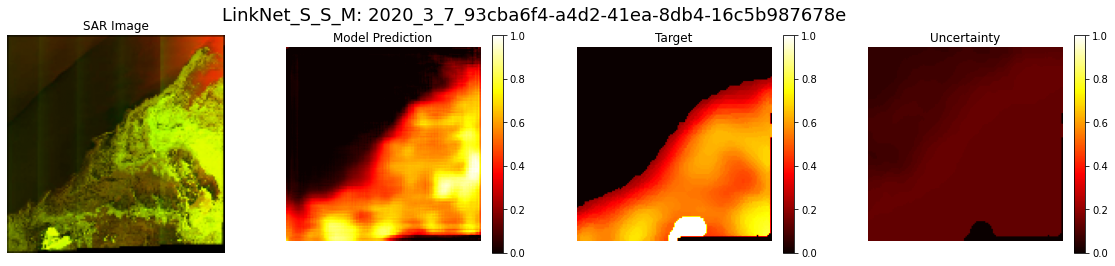

In [ ]:
#@title ##Generate an Individual Prediction
date_uuid = "2020_3_7_93cba6f4-a4d2-41ea-8db4-16c5b987678e" #@param {type:"string"}
#model_description = "LinkNet_S_S_M" 
# Get the image path
year  = date_uuid.split("_")[0]
month = date_uuid.split("_")[1]
day   = date_uuid.split("_")[2]
uuid  = date_uuid.split("_")[3]

# Load the resampled SAR image
os.chdir(os.path.join(dataset_location_path, dataset_name, sentinel_1_folder))
image = np.zeros((1, image_dimension, image_dimension, 2))
image[0, :, :, :2] = cv2.cvtColor(cv2.imread(sentinel_1_resampled_name.format(year, month, day, uuid)), cv2.COLOR_BGR2RGB)[:, :, :2] / 255
disp_image = np.zeros((image_dimension, image_dimension, 3))
disp_image[:, :, :2] = image[0, :, :, :]

# Load the concentration label, and uncertainty patch
os.chdir(os.path.join(dataset_location_path, dataset_name, cmems_label_folder))
concentration = cv2.medianBlur(cv2.imread(concentration_name.format(year, month, day, uuid), cv2.IMREAD_GRAYSCALE), 5) / 100
uncertainty   = cv2.medianBlur(cv2.imread(uncertainty_name.format(year, month, day, uuid),   cv2.IMREAD_GRAYSCALE), 5) / 100

# Get a prediction from the model
#model = load_model()
prediction = model.predict(image)[0, :, :, 0]

# Plot the results
plt.figure(figsize=(20,4))
plt.suptitle(model_description + ": " + date_uuid, fontsize=18)

plt.subplot(1,4,1)
plt.imshow(disp_image, vmin=0, vmax=1)
plt.title("SAR Image")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(prediction, cmap="hot", vmin=0, vmax=1)
plt.title("Model Prediction")
plt.axis('off')
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(concentration, cmap="hot", vmin=0, vmax=1)
plt.title("Target")
plt.axis('off')
plt.colorbar()

plt.subplot(1,4,4)
plt.imshow(uncertainty, cmap="hot", vmin=0, vmax=1)
plt.title("Uncertainty")
plt.axis('off')
plt.colorbar()

plt.show()